In [23]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

from tensorflow.keras.layers import StringLookup

import pandas as pd

In [3]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

In [4]:
loaded_test= keras.models.load_model("prediction_model.keras", custom_objects={
  'CTCLayer': CTCLayer
})

# Data Ingestion

In [5]:
base_path = '../data/IAM_Words'
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)
        
        
np.random.shuffle(words_list)


split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples

test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [6]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

In [7]:
test_labels_cleaned = clean_labels(test_labels)

In [8]:
characters= ['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
max_len = 21



AUTOTUNE = tf.data.AUTOTUNE


# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [9]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image



batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [10]:
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

# True Inference, with the test

2/2 [==============================] - 0s 35ms/step


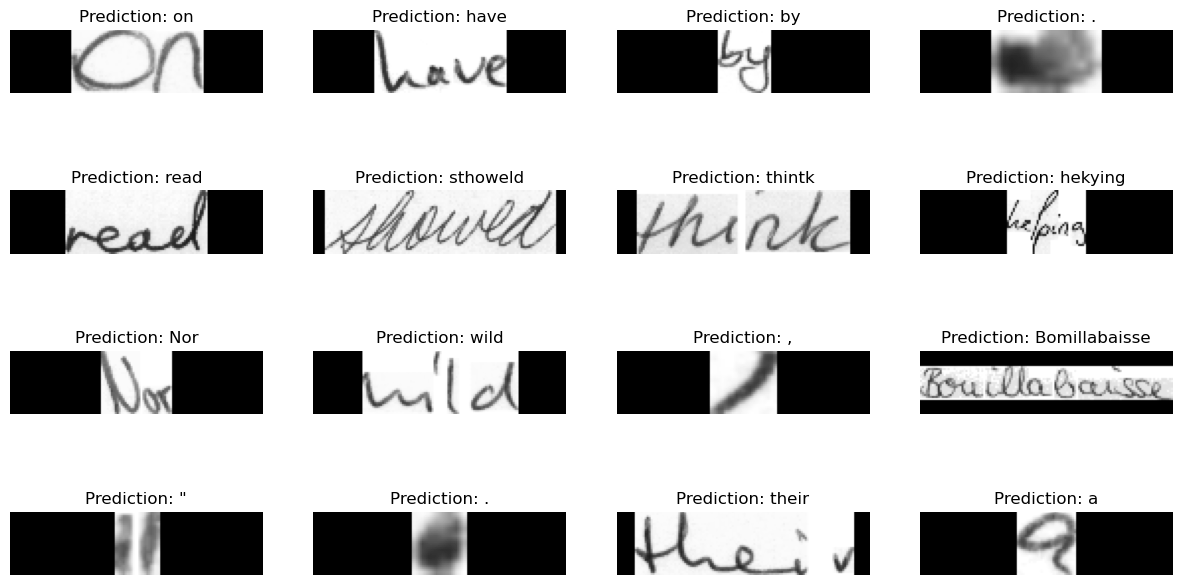

In [12]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = loaded_test.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

# new images

Ok first, let's get a good size for input images

Let's get the average size of every image


In [13]:
len(words_list)

96456

In [16]:
w_list = [line.strip() for line in words_list]

In [22]:
w_list[0].split()

['e02-021-06-00', 'ok', '194', '326', '1743', '131', '97', 'IN', 'at']

In [20]:
w_list[2]

'n04-156-04-01 ok 166 518 1443 164 93 CC and'

In [18]:
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#

In [21]:
w_list[2].split()

['n04-156-04-01', 'ok', '166', '518', '1443', '164', '93', 'CC', 'and']

In [24]:

bigL = []
for line in w_list:
    w_dict = {}
    l = line.strip().split()
    w_dict['word_id'] = l[0]
    w_dict['seg_result'] = l[1]
    w_dict['gray_level'] = l[2]
    w_dict['x'] = int(l[3])
    w_dict['y'] = int(l[4])
    w_dict['w'] = int(l[5])
    w_dict['h'] = int(l[6])
    w_dict['grammatical_tag'] = l[7]
    w_dict['word'] = l[8]
    
    bigL.append(w_dict)
    

In [26]:
df = pd.DataFrame(bigL)

In [27]:
df.head()

,word_id,seg_result,gray_level,x,y,w,h,grammatical_tag,word
0,e02-021-06-00,ok,194,326,1743,131,97,IN,at
1,c03-096c-03-03,ok,187,1235,1295,195,88,IN,with
2,n04-156-04-01,ok,166,518,1443,164,93,CC,and
3,c02-007-05-07,ok,187,1588,1659,249,58,NP$,Wicki's
4,a05-029-03-03,ok,176,927,1310,131,47,NPT,Mr.


In [33]:
df['seg_result'].value_counts(normalize=True)

seg_result
ok    1.0
Name: proportion, dtype: float64

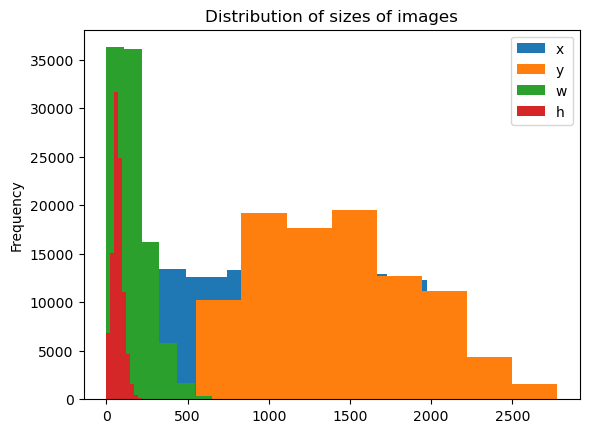

In [34]:
df['x'].plot.hist()
df['y'].plot.hist()
df['w'].plot.hist()
df['h'].plot.hist()
plt.title('Distribution of sizes of images')
plt.legend()

<Axes: ylabel='Frequency'>

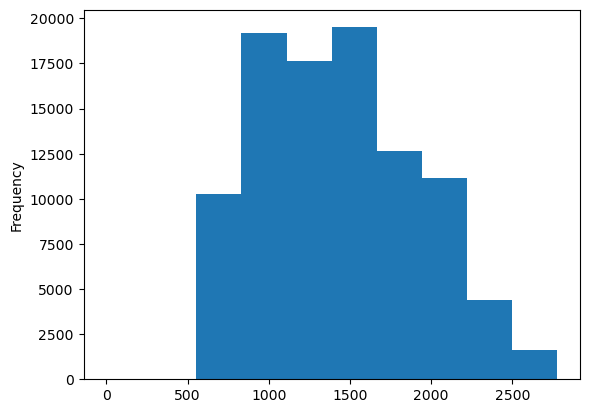

In [ ]:
import streamlit as st
import cv2
from PIL import Image
import tensorflow as tf

# Load your Keras model for handwriting recognition
model = tf.keras.models.load_model('your_model_path')

st.title("Handwritten Word Recognition")

# Upload a scanned file
uploaded_image = st.file_uploader("Upload a scanned image", type=["jpg", "png", "jpeg"])

if uploaded_image is not None:
    # Display the uploaded image
    image = Image.open(uploaded_image)
    st.image(image, caption='Uploaded Image', use_column_width=True)

    # Perform recognition when a button is clicked
    if st.button("Recognize"):
        # Process the image for recognition (e.g., resizing, preprocessing)
        # For OCR, you may want to use Optical Character Recognition techniques
        # You can use the OpenCV library to preprocess the image

        # Convert the image to grayscale
        image = cv2.cvtColor(cv2.imread(uploaded_image), cv2.COLOR_BGR2GRAY)
        
        # Perform any other preprocessing necessary

        # Make a prediction using your Keras model
        # Ensure the input to the model matches the format it was trained on
        prediction = model.predict(preprocessed_image)

        # Convert the model output to a readable word
        recognized_word = "Your recognition logic here"

        # Display the recognized word
        st.write(f"Recognized Word: {recognized_word}")